In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [3]:
clothes_info = {
    0: '0_coat', 1: '1_padding', 2: '2_shortsleeve',
    3: '3_longsleeve', 4: '4_shirt', 5: '5_pants'
}

# data augmentation

In [4]:
base_dir = '/content/drive/MyDrive/ktintern/datasets'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
input_size = (299, 299)

train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=input_size)

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=input_size)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=input_size)

Found 485 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


## transfer learning - inception v3 , just classifier

In [10]:
inceptionV3 = tf.keras.applications.InceptionV3(include_top=True)
base_inputs = inceptionV3.layers[0].input
base_outputs = inceptionV3.layers[-2].output
classifier = tf.keras.layers.Dense(6, activation='softmax')(base_outputs)
inceptionV3_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

inceptionV3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [11]:
inceptionV3_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

checkpoint_path = '/content/drive/MyDrive/ktintern/checkpoints/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'inceptionV3_model_nodress.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [13]:
inceptionV3_history = inceptionV3_model.fit(train_generator,
                                              validation_data=validation_generator,
                                              epochs=50,
                                              callbacks=[cb_checkpoint, early_stopping]
                                              )

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.3050 - accuracy: 0.5753
Epoch 00001: val_loss improved from inf to 33.43847, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_model_nodress.ckpt
25/25 [==============================] - 120s 4s/step - loss: 1.3050 - accuracy: 0.5753 - val_loss: 33.4385 - val_accuracy: 0.2086
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.7320
Epoch 00002: val_loss improved from 33.43847 to 19.79117, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_model_nodress.ckpt
25/25 [==============================] - 29s 1s/step - loss: 0.7697 - accuracy: 0.7320 - val_loss: 19.7912 - val_accuracy: 0.2014
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8309
Epoch 00003: val_loss improved from 19.79117 to 2.00734, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_model_nodress.ckpt
25/25 [=========

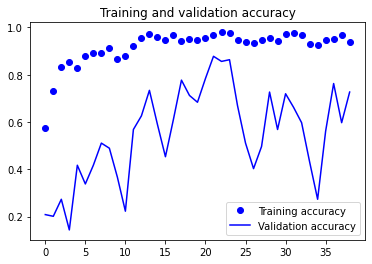

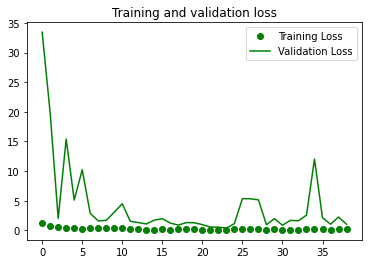

In [14]:
acc = inceptionV3_history.history['accuracy']
val_acc = inceptionV3_history.history['val_accuracy']
loss = inceptionV3_history.history['loss']
val_loss = inceptionV3_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
inceptionV3_model.save(os.path.join(checkpoint_path, 
                                       'inceptionV3_model_nodress.h5'))
inceptionV3_model = tf.keras.models.load_model(os.path.join(checkpoint_path, 
                                                               'inceptionV3_model_nodress.h5'))

loss, acc = inceptionV3_model.evaluate(test_generator, verbose=2)
print("모델의 테스트 정확도: {:5.2f}%".format(100*acc))

4/4 - 10s - loss: 0.7008 - accuracy: 0.7917 - 10s/epoch - 3s/step
모델의 테스트 정확도: 79.17%


## transfer learning - inception v3 , fine tunning

In [21]:
inception_V3 = tf.keras.applications.InceptionV3(weights='imagenet',input_shape=(299,299,3), include_top=True)

for layer in inception_V3.layers[:]:
  layer.trainable = True

base_inputs = inception_V3.layers[0].input
base_outputs = inception_V3.layers[-2].output
classifier = tf.keras.layers.Dense(6, activation='softmax')(base_outputs)
inceptionV3_ft_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

inceptionV3_ft_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [22]:
inceptionV3_ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
checkpoint_path = '/content/drive/MyDrive/ktintern/checkpoints/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'inceptionV3_ft_model_nodress.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [24]:
inceptioinV3_ft_history = inceptionV3_ft_model.fit(train_generator,
                                                   validation_data=validation_generator,
                                                   epochs=50,
                                                   callbacks=[cb_checkpoint, early_stopping]
                                                   )

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.6103
Epoch 00001: val_loss improved from inf to 2.87458, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_ft_model_nodress.ckpt
25/25 [==============================] - 39s 1s/step - loss: 1.0996 - accuracy: 0.6103 - val_loss: 2.8746 - val_accuracy: 0.2230
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.7608
Epoch 00002: val_loss did not improve from 2.87458
25/25 [==============================] - 27s 1s/step - loss: 0.7520 - accuracy: 0.7608 - val_loss: 55.0279 - val_accuracy: 0.2014
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8577
Epoch 00003: val_loss improved from 2.87458 to 2.42931, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_ft_model_nodress.ckpt
25/25 [==============================] - 28s 1s/step - loss: 0.4879 - accuracy: 0.8577 - val_loss: 2.4293 - val_

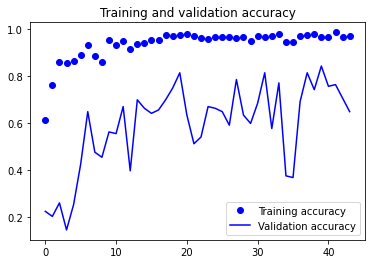

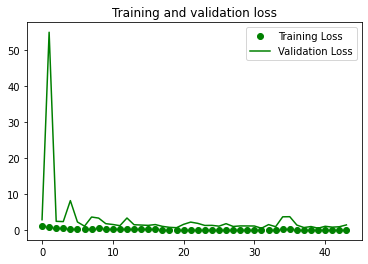

In [25]:
acc = inceptioinV3_ft_history.history['accuracy']
val_acc = inceptioinV3_ft_history.history['val_accuracy']
loss = inceptioinV3_ft_history.history['loss']
val_loss = inceptioinV3_ft_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
inceptionV3_ft_model.save(os.path.join(checkpoint_path, 
                                       'inceptionV3_ft_model_nodress.h5'))

In [27]:
inceptionV3_ft_model = tf.keras.models.load_model(os.path.join(checkpoint_path, 
                                                               'inceptionV3_ft_model_nodress.h5'))

loss, acc = inceptionV3_ft_model.evaluate(test_generator, verbose=2)
print("모델의 테스트 정확도: {:5.2f}%".format(100*acc))

4/4 - 3s - loss: 2.0573 - accuracy: 0.4861 - 3s/epoch - 685ms/step
모델의 테스트 정확도: 48.61%
